## Tic-Tac-Toe Agent
​
In this notebook, we will build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values
        
By:
**Sameer Gadicherla - March 31 2021 Batch**

#### Importing libraries

In [29]:
from TCGame_Env import TicTacToe #import your class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [30]:
env = TicTacToe()

In [31]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [32]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [33]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy


In [34]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        agent_actions,env_actions = env.action_space(state)   #Exploration: randomly choosing and action
        action = random.choice(agent_actions)
    return action

#### Tracking the state-action pairs for checking convergence

In [35]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [36]:
# Initialise states to be tracked
def initialise_tracking_states():
    ### let's take some random states and random actions and initialise them
    sample_state_actions = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-3-x-x-1-x-x-x-x',(7,5)),('x-5-x-x-x-x-5-7-x',(8,2))]
    for state,action in sample_state_actions:
         States_track[state][action] = []

In [37]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [38]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [39]:
###initialise the states
initialise_tracking_states()

In [40]:
States_track

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(6, 5): [], (1, 9): []},
             'x-3-x-x-1-x-x-x-x': {(7, 5): []},
             'x-5-x-x-x-x-5-7-x': {(8, 2): []}})

#### Define hyperparameters

In [41]:
EPISODES = 15000000
LR = 0.01   # learning rate

GAMMA = 0.9
threshold = 3000      
policy_threshold = 50000

max_epsilon = 1.0
min_epsilon = 0.001

### Q-update loop

In [42]:
start_time = time.time()

for episode in range(EPISODES):
    env = TicTacToe()
    curr_state = env.state
    isTerminated = False
    add_to_dict(curr_state)
    total_reward = 0

    while not isTerminated:
        current_state_ele = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        out_state, reward, isTerminated = env.step(curr_state, curr_action)

        out_state_ele = Q_state(out_state)
        add_to_dict(out_state)

        if isTerminated:
            Q_dict[current_state_ele][curr_action] += LR * (
                (reward - Q_dict[current_state_ele][curr_action]))
        else:
            max_out = max(Q_dict[out_state_ele],
                           key=Q_dict[out_state_ele].get)
            Q_dict[current_state_ele][curr_action] += LR * (
                (reward + (GAMMA * (Q_dict[out_state_ele][max_out]))) -
                Q_dict[current_state_ele][curr_action])

        curr_state = out_state
        total_reward += reward

    # Tracking the Q-Values here
    
    if (episode == threshold-1):        
        initialise_tracking_states()

    if ((episode+1) % threshold) == 0:   #every 3000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    # Saving the Policy here
    
    if ((episode+1)% policy_threshold ) == 0:  #every 50000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')

elapsed_time = time.time() - start_time
save_obj(States_track, 'States_tracked')
save_obj(Q_dict, 'Policy')
print(elapsed_time)                                               

11069.354777812958


In [19]:
##load the policy from the pickle file like below
loadedPolicy = open("Policy.pkl", "rb")

loadedPolicy = pickle.load(loadedPolicy)

In [20]:
type(loadedPolicy)

collections.defaultdict

#### Check the Q-dictionary

In [21]:
Q_dict = loadedPolicy
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 0.5647736743611017,
              (0, 3): 0.06634592132535784,
              (0, 5): -0.4269491486043096,
              (0, 7): 0.6266645731935531,
              (0, 9): 0.5732864835008582,
              (1, 1): 1.3292219376604462,
              (1, 3): 0.9159878181009475,
              (1, 5): 0.3729540831775882,
              (1, 7): 1.4369241175151095,
              (1, 9): 0.9831508781052114,
              (2, 1): 1.2162263776090863,
              (2, 3): 0.2848666437756809,
              (2, 5): 0.9413368238200938,
              (2, 7): 0.14777496906483173,
              (2, 9): 0.35410725459491765,
              (3, 1): 3.45795501577751,
              (3, 3): 1.1727198255022917,
              (3, 5): 1.9467910025514068,
              (3, 7): 1.1389457999085184,
              (3, 9): 0.8086327253292775,
              (4, 1): 0.689137281694045,
              (4, 3): 0.023244721406742365,
              (4, 5): -0.359915441

In [22]:
len(Q_dict)

4410727

In [23]:
# checking for one of the states - that which action your agent thinks is the best
def getNextStep(state,Q_dict):
    return max(Q_dict[state],
                           key=Q_dict[state].get)

##State
#   5 | x | 7
#   ----------
#   x | x | x
#   ----------
#   8 | x | 2

##expected Answer
#   5 | 3 | 7
#   ----------
#   x | x | x
#   ----------
#   8 | x | 2
getNextStep("5-x-7-x-x-x-8-x-2",Q_dict) 


(1, 3)

#### the above action is the right answer as 7+3+5 = 15 and 3 has to placed at the second column in first row

### Epsilon - decay check

In [24]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

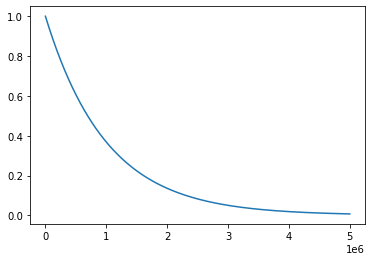

In [25]:
plt.plot(time, epsilon)
plt.show()